In [ ]:
import  joblib

import  pandas                  as pd
import  numpy                   as np
import  seaborn                 as sns
import  matplotlib              as mpl
import  matplotlib.pyplot       as plt

from    warnings                import simplefilter
from    sklearn.svm             import SVC
from    sklearn.tree            import DecisionTreeClassifier
from    sklearn.metrics         import accuracy_score, classification_report, confusion_matrix
from    sklearn.ensemble        import RandomForestClassifier
from    sklearn.linear_model    import LogisticRegression
from    sklearn.preprocessing   import OneHotEncoder
from    sklearn.model_selection import GridSearchCV, train_test_split

# Set high-resolution matplotlib plots
mpl.rcParams['figure.dpi'] = 300

# Disable scikit warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

### **Data Pre-Processing**

In [13]:
# Load dataset file
dataset = pd.read_csv(r"./Dataset/dataset.csv")

In [ ]:
def clean_data(x):                                                                            #we define a "cleaning" function which removes any spaces in front or after the string
    if isinstance(x, str):                                                                    #Check if (object,type)
        return x.strip().replace("  ", " ").replace(" _", "_").replace("_ ", "_")             #eemove spaces from both ends of the string
    else:
        return x  

# apply the function to each column
for col in dataset.columns:
    dataset[col] = dataset[col].map(clean_data)

# List of all symptom columns
symptom_cols = [
    'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5',
    'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10',
    'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15',
    'Symptom_16', 'Symptom_17'
]

# Create the empty list to store all symptoms
all_symptoms = []

for col in symptom_cols:                           # go through each Symptom_1 to Symptom_17 column
    for symptom in dataset[col]:                   # go through every value in that column
        if pd.notna(symptom):                      # check if the cell is not nan
            all_symptoms.append(symptom)           # add it to the list

unique_symptoms = sorted(list(set(all_symptoms)))  #to remove the duplicates with set, we make them again a list (makes it usable for indexing and loops) and we soort them alphabetically in order to read them easier

#create a list of all diseases
disease_list = dataset['Disease'].unique()      #we use the unique function to get all diseases

#print how many symptoms we found
print("Number of unique symptoms:", len(unique_symptoms))
print("Symptoms:", unique_symptoms)

print("Number of unique diseases:", len(disease_list))
print("Symptoms:", disease_list)

# Create one-hot encoded DataFrame for symptoms
binary = pd.DataFrame()                  #Create a new, empty table (DataFrame) named binary to hold the simplified data
binary['Disease'] = dataset['Disease']  #Copy the disease column from the original dataset (dataset) into the binary table

#for each syptom we check each row
for symptom in unique_symptoms:
    binary[symptom] = dataset[symptom_cols].eq(symptom).any(axis=1).astype(int)
#so what we basically did : For each symptom in your list, check every patient.Mark 1 if the patient has this symptom anywhere, or 0 if not

Number of unique symptoms: 131
Symptoms: ['abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 'chills', 'cold_hands_and_feets', 'coma', 'congestion', 'constipation', 'continuous_feel_of_urine', 'continuous_sneezing', 'cough', 'cramps', 'dark_urine', 'dehydration', 'depression', 'diarrhoea', 'dischromic_patches', 'distention_of_abdomen', 'dizziness', 'drying_and_tingling_lips', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 'fast_heart_rate', 'fatigue', 'fluid_overload', 'foul_smell_of urine', 'headache', 'high_fever', 'hip_joint_pain', 'history_of_alcohol_consumption', 'increased_appetite', 'indigestion', 'inflammatory_nails', 'internal_itching', 'irregular_sugar_level', '

In [15]:
#Prepare the data
X_binary = binary.drop(columns=['Disease'])  # All columns except Disease
y_binary = binary['Disease']  # Target column

#Split the data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.7, random_state=42)

### **Decision Tree**

In [16]:
param_grid = {'ccp_alpha': [0.1, .01, .001, .0001],
              'max_depth' : range(15,25,1),
              'criterion' :['gini', 'entropy','log_loss'],
             }

model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_

#Save the model

joblib.dump(final_model, './Models_Fulldata/decision_tree_model.pkl')

print(final_model)

# Train
final_model.fit(X_train_bin, y_train_bin)

# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=20,
                       random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       0.87      0.93      0.90        84
                                  Acne       1.00      0.93      0.96        87
                   Alcoholic hepatitis       1.00      1.00      1.00        82
                               Allergy       0.74      1.00      0.85        86
                             Arthritis       1.00      0.93      0.96        86
                      Bronchial Asthma       1.00      0.93      0.96        87
                  Cervical spondylosis       1.00      0.93      0.96        87
                           Chicken pox       1.00      0.86      0.93        87
                   Ch

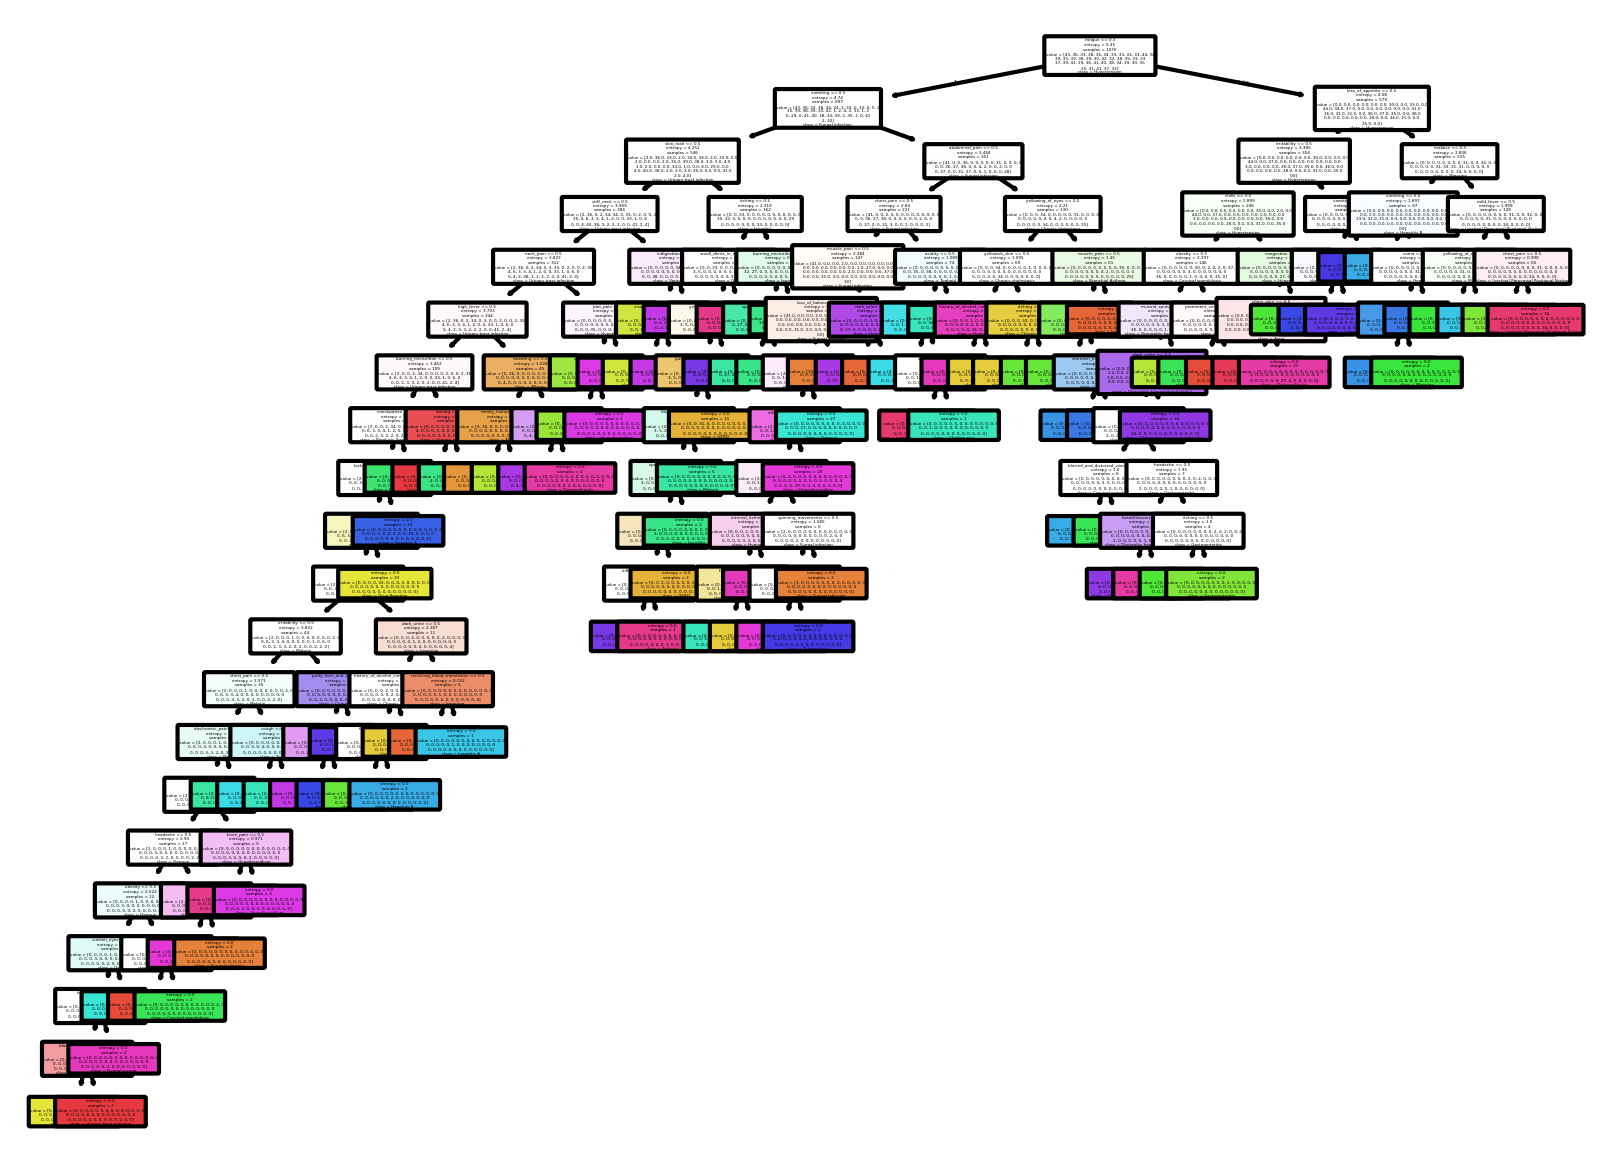

In [17]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plot_tree(final_model, filled=True, feature_names=X_binary.columns, class_names=y_binary.unique(), rounded=True)
plt.savefig("./Plots/Classifier_Fulldata/tree_graph.pdf")

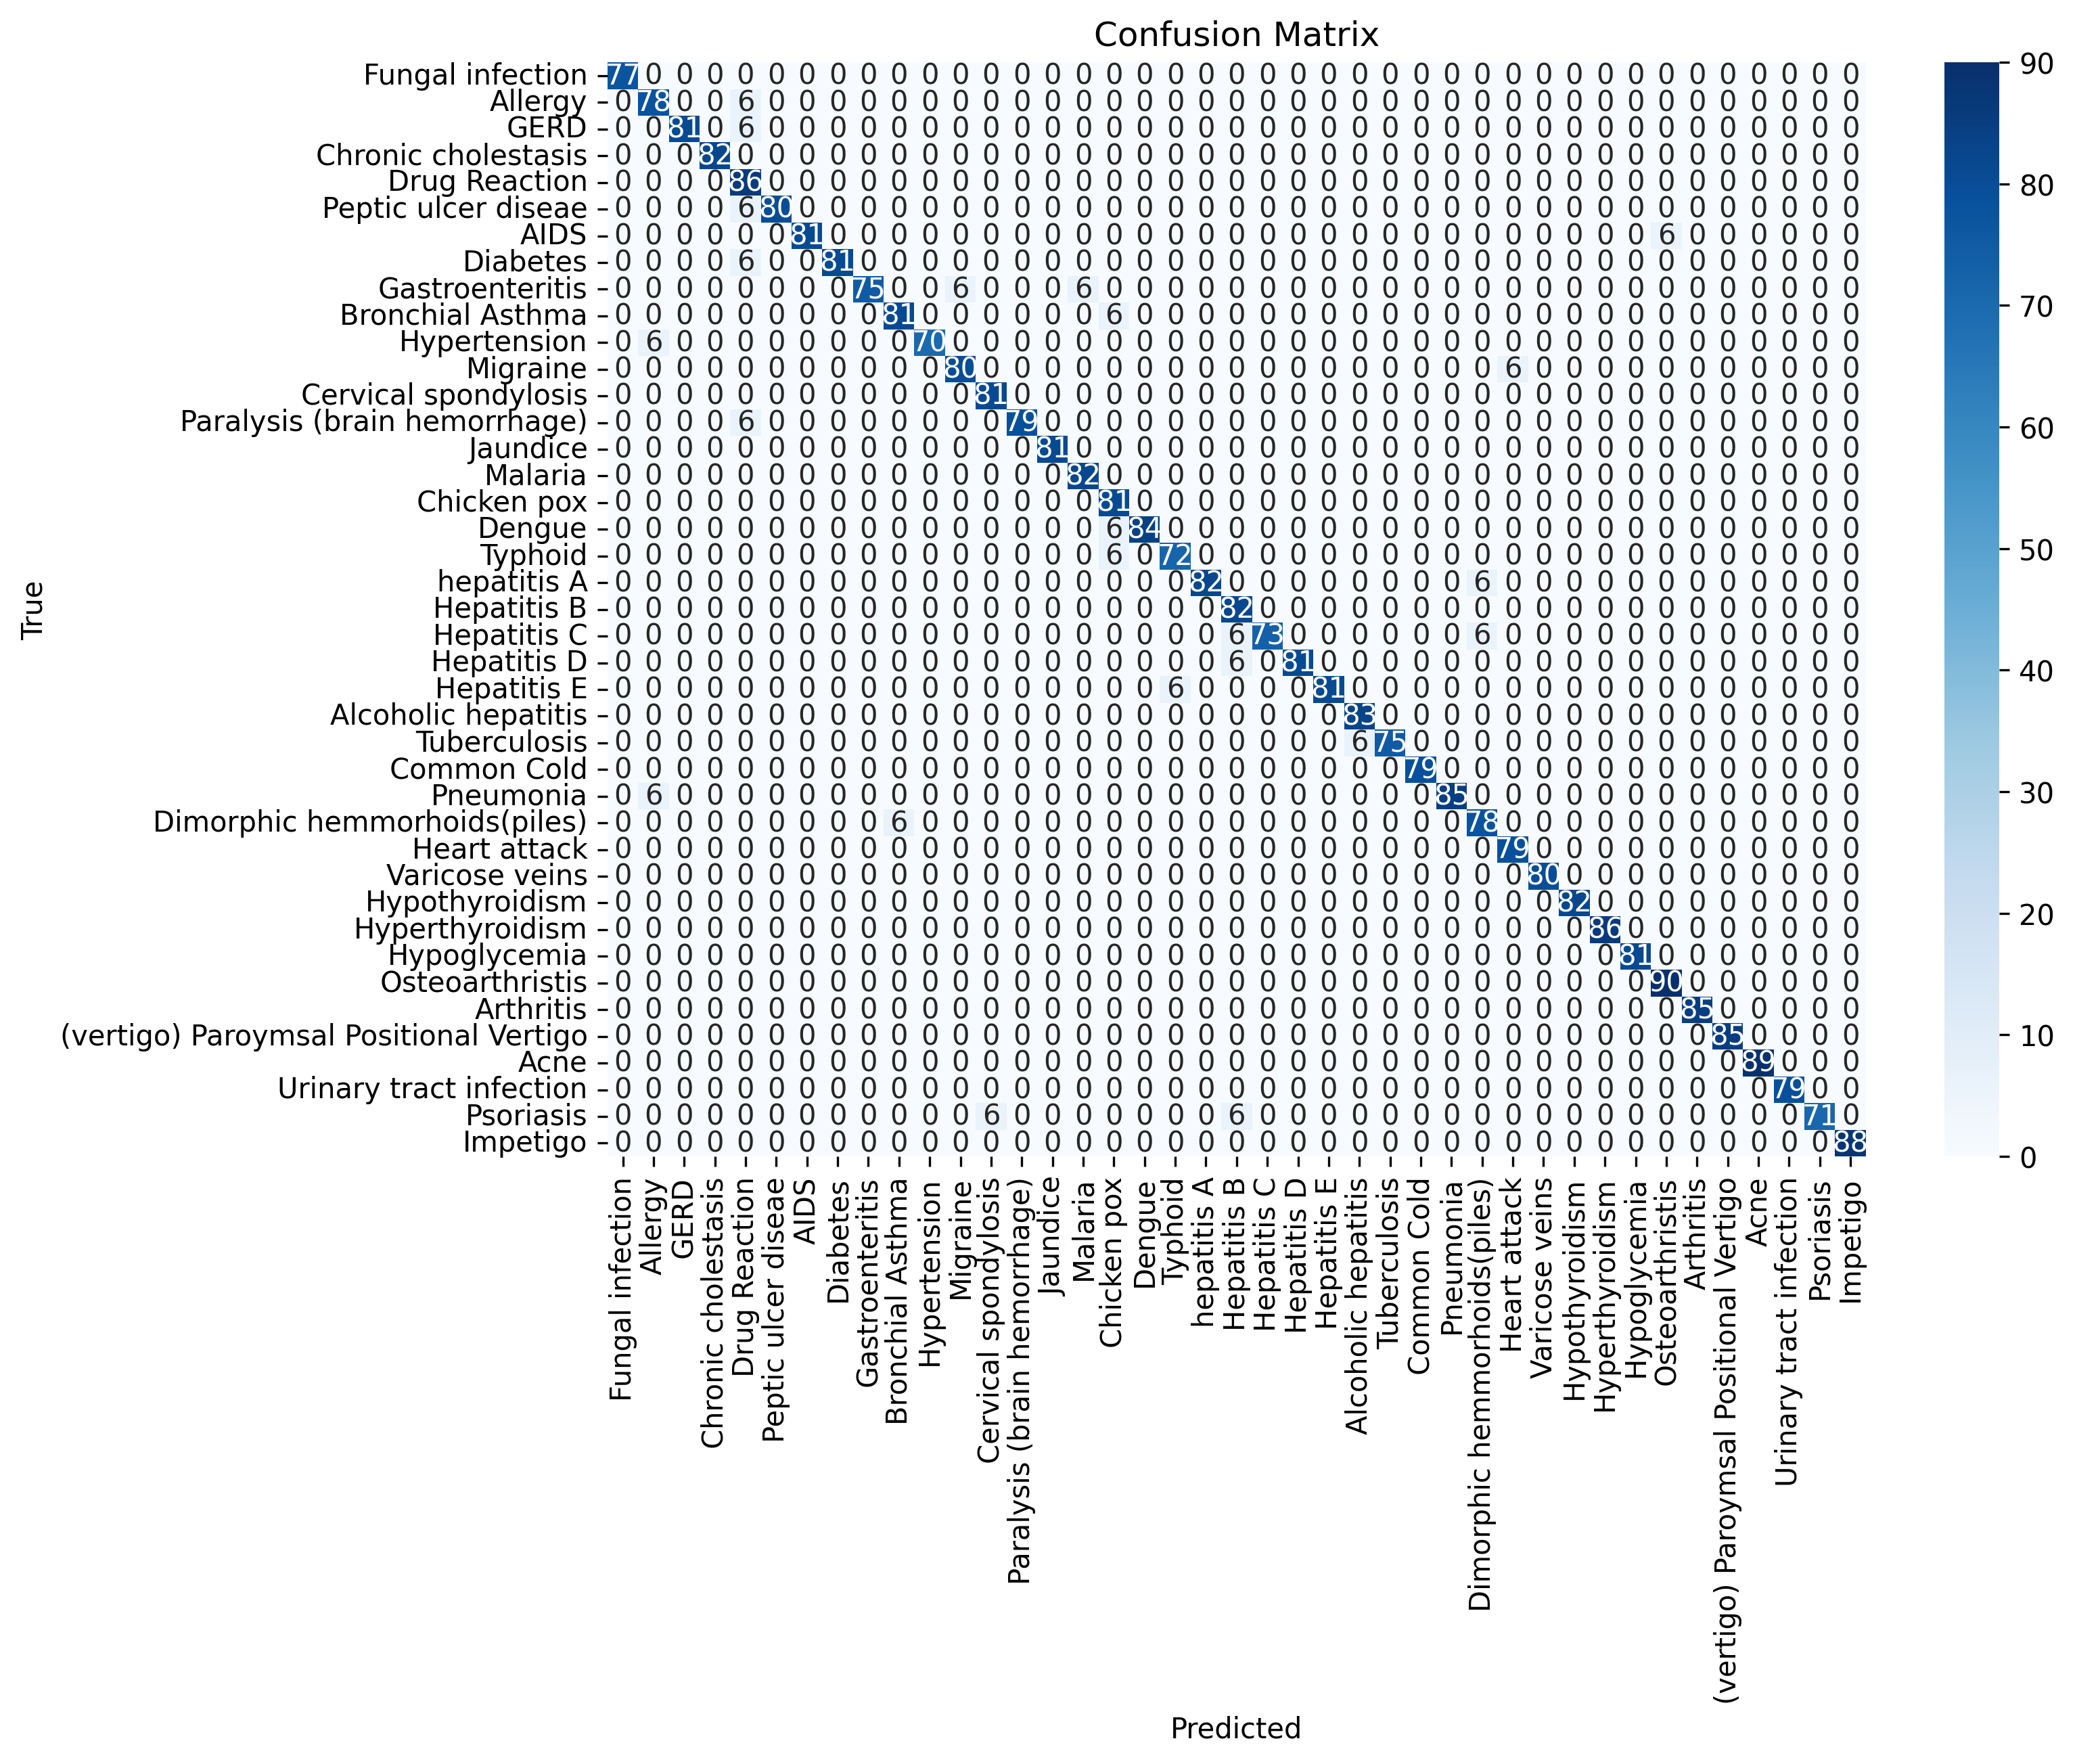

In [18]:
# Create confusion matrix
cm = confusion_matrix(y_test_bin, predictions)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_binary.unique(), yticklabels=y_binary.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Save the model

### **Random Forest**

In [19]:
param_grid = {'n_estimators': range(40, 46, 1),
              'max_depth' : range(12,15,1),
              'criterion' :['gini', 'entropy','log_loss'],
             }

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_
joblib.dump(final_model, './Models_Fulldata/random_forest_model.pkl')
print(final_model)

# Train
final_model.fit(X_train_bin, y_train_bin)

# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
RandomForestClassifier(max_depth=13, n_estimators=41, random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       1.00      1.00      1.00        84
                                  Acne       1.00      1.00      1.00        87
                   Alcoholic hepatitis       1.00      1.00      1.00        82
                               Allergy       1.00      1.00      1.00        86
                             Arthritis       1.00      1.00      1.00        86
                      Bronchial Asthma       1.00      1.00      1.00        87
                  Cervical spondylosis       1.00      1.00      1.00        87
                           Chicken pox       1.00      1.00      1.00        87
                   Chronic cholestasis       1.00      1.00      1

### **Logistic Regression**

In [20]:
# Create a pipeline with StandardScaler and LogisticRegression
param_grid = {'tol' : [.001,0.02,.005,.01,.02],
                'C' : [0.1, 0.5, 1, 2, 5],
              'solver' :['lbfgs', 'newton-cg', 'sag', 'saga'],
             }

# Create a logistic regression model
model = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_
joblib.dump(final_model, './Models_Fulldata/logistic_regression_model.pkl')
print(final_model)

# Train
final_model.fit(X_train_bin, y_train_bin)

# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
LogisticRegression(C=0.1, random_state=42, tol=0.001)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       1.00      1.00      1.00        84
                                  Acne       1.00      1.00      1.00        87
                   Alcoholic hepatitis       1.00      1.00      1.00        82
                               Allergy       1.00      1.00      1.00        86
                             Arthritis       1.00      1.00      1.00        86
                      Bronchial Asthma       1.00      1.00      1.00        87
                  Cervical spondylosis       1.00      1.00      1.00        87
                           Chicken pox       1.00      1.00      1.00        87
                   Chronic cholestasis       1.00      1.00      1.00        87
  

### **Support Vector Classifier**

In [21]:
param_grid = {'C' : [.01,.02,.05,0.1, .2],
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree' : [1,2,3,4],
             }

# Create a logistic regression model
model = SVC(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)
final_model = grid_search.best_estimator_

# Save model
joblib.dump(final_model, './Models_Fulldata/support_vector_model.pkl')

print(final_model)
# Train
final_model.fit(X_train_bin, y_train_bin)
# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
SVC(C=0.02, degree=1, kernel='linear', random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       1.00      1.00      1.00        84
                                  Acne       1.00      1.00      1.00        87
                   Alcoholic hepatitis       1.00      1.00      1.00        82
                               Allergy       1.00      1.00      1.00        86
                             Arthritis       1.00      1.00      1.00        86
                      Bronchial Asthma       1.00      1.00      1.00        87
                  Cervical spondylosis       1.00      1.00      1.00        87
                           Chicken pox       1.00      1.00      1.00        87
                   Chronic cholestasis       1.00      1.00      1.00        87
 

### **K-Nearest Neighbors**

In [154]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train_bin, y_train_bin)

y_pred = knn.predict(X_test_bin)

accuracy = accuracy_score(y_test_bin, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [156]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
}

# Create a K-nearest neighbors model
model = KNeighborsClassifier(n_neighbors=5)

# Create a grid search object
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, verbose=True)
# Perform grid search using the training data
grid_search.fit(X_train_bin, y_train_bin)
# Get the best model from grid search
final_model = grid_search.best_estimator_

# Save model
joblib.dump(final_model, './Models_Fulldata/k_nearest_neighbors_model.pkl')
# Print the best model
print(final_model)

# Train the best model
final_model.fit(X_train_bin, y_train_bin)
# Evaluate the best model
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
KNeighborsClassifier(n_neighbors=3)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       1.00      1.00      1.00        84
                                  Acne       1.00      1.00      1.00        87
                   Alcoholic hepatitis       1.00      1.00      1.00        82
                               Allergy       1.00      1.00      1.00        86
                             Arthritis       1.00      1.00      1.00        86
                      Bronchial Asthma       1.00      1.00      1.00        87
                  Cervical spondylosis       1.00      1.00      1.00        87
                           Chicken pox       1.00      1.00      1.00        87
                   Chronic cholestasis       1.00      1.00      1.00        87
                       

### **Neural Network**

In [148]:
# Prepare data for neural network
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.utils import to_categorical

X_nn, y_nn = dataset[symptom_cols], dataset['Disease']

# One-hot encode the symptoms
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_nn_enc = encoder.fit_transform(X_nn)

# Encode diseases into unique disease labels
y_nn_enc = LabelEncoder().fit_transform(y_nn)
# Convert to categorical format
y_nn_cat = to_categorical(y_nn_enc)

# Generate train and test sets
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn_enc, y_nn_cat, train_size=0.7, test_size = 0.3, random_state=42)

In [149]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks    import EarlyStopping

from sklearn.base             import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics          import accuracy_score
# ─── 1) A sklearn-style wrapper for your Keras network ────────────────────
class KerasNN(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 activation='relu',
                 layer1=64,
                 layer2=32,
                 dropout=0.5,
                 l2_reg=0.001,
                 batch_size=16,
                 epochs=50,
                 random_state=42):
        self.activation  = activation
        self.layer1      = layer1
        self.layer2      = layer2
        self.dropout     = dropout
        self.l2_reg      = l2_reg
        self.batch_size  = batch_size
        self.epochs      = epochs
        self.random_state= random_state
        self.model       = None

    def _build_model(self, input_dim, n_classes):
        """(Re)build the Keras model using current hyperparameters."""
        tf.keras.utils.set_random_seed(self.random_state)
        m = Sequential([
            Input(shape=(input_dim,)),
            Dense(self.layer1, activation=self.activation,
                  kernel_regularizer=l2(self.l2_reg)),
            Dropout(self.dropout),
            Dense(self.layer2, activation=self.activation,
                  kernel_regularizer=l2(self.l2_reg)),
            Dropout(self.dropout),
            Dense(n_classes, activation='softmax')
        ])
        m.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return m

    def fit(self, X, y):
        n_classes = len(np.unique(y))
        input_dim = X.shape[1]
        self.model = self._build_model(input_dim, n_classes)
        # EarlyStopping on a 20% holdout from the X/y passed to fit()
        es = EarlyStopping(monitor='val_loss', patience=5,
                           restore_best_weights=True, verbose=0)
        self.model.fit(
            X, y,
            validation_split=0.30,
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[es],
            verbose=0
        )
        return self

    def predict(self, X):
        proba = self.model.predict(X, verbose=0)
        return np.argmax(proba, axis=1)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

param_grid = {
    'activation':  ['relu'],
    'layer1':      [32],
    'layer2':      [16],
    'dropout':     [0.2],
    'l2_reg':      [10-3],
    'batch_size':  [16],     # fix to 16 for speed
    'epochs':      [50],     # fix to 50 for speed
}

grid = GridSearchCV(
    estimator=KerasNN(),
    param_grid=param_grid,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='accuracy',
    verbose=2,
    n_jobs=1
)

grid.fit(X_nn_enc, y_nn_enc)

print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
 

[CV] END activation=relu, batch_size=16, dropout=0.2, epochs=50, l2_reg=7, layer1=32, layer2=16; total time=   2.3s
[CV] END activation=relu, batch_size=16, dropout=0.2, epochs=50, l2_reg=7, layer1=32, layer2=16; total time=   2.0s
[CV] END activation=relu, batch_size=16, dropout=0.2, epochs=50, l2_reg=7, layer1=32, layer2=16; total time=   2.2s
[CV] END activation=relu, batch_size=16, dropout=0.2, epochs=50, l2_reg=7, layer1=32, layer2=16; total time=   2.0s
[CV] END activation=relu, batch_size=16, dropout=0.2, epochs=50, l2_reg=7, layer1=32, layer2=16; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Best params: {'activation': 'relu', 'batch_size': 16, 'dropout': 0.2, 'epochs': 50, 'l2_reg': 7, 'layer1': 32, 'layer2': 16}
Best CV acc: nan


Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1829 - loss: 3.5319 - val_accuracy: 0.8569 - val_loss: 1.9356
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.7943 - loss: 1.5970 - val_accuracy: 0.9981 - val_loss: 0.5288
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.9303 - loss: 0.6867 - val_accuracy: 1.0000 - val_loss: 0.3393
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.9584 - loss: 0.5077 - val_accuracy: 1.0000 - val_loss: 0.2940
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.9722 - loss: 0.4289 - val_accuracy: 1.0000 - val_loss: 0.2773
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.9692 - loss: 0.4227 - val_accuracy: 1.0000 - val_loss: 0.2649
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.9695 - loss: 0.3913 - val_accuracy: 1.0000 - val_loss: 0.2535
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.9811 - loss: 0.3558 - va

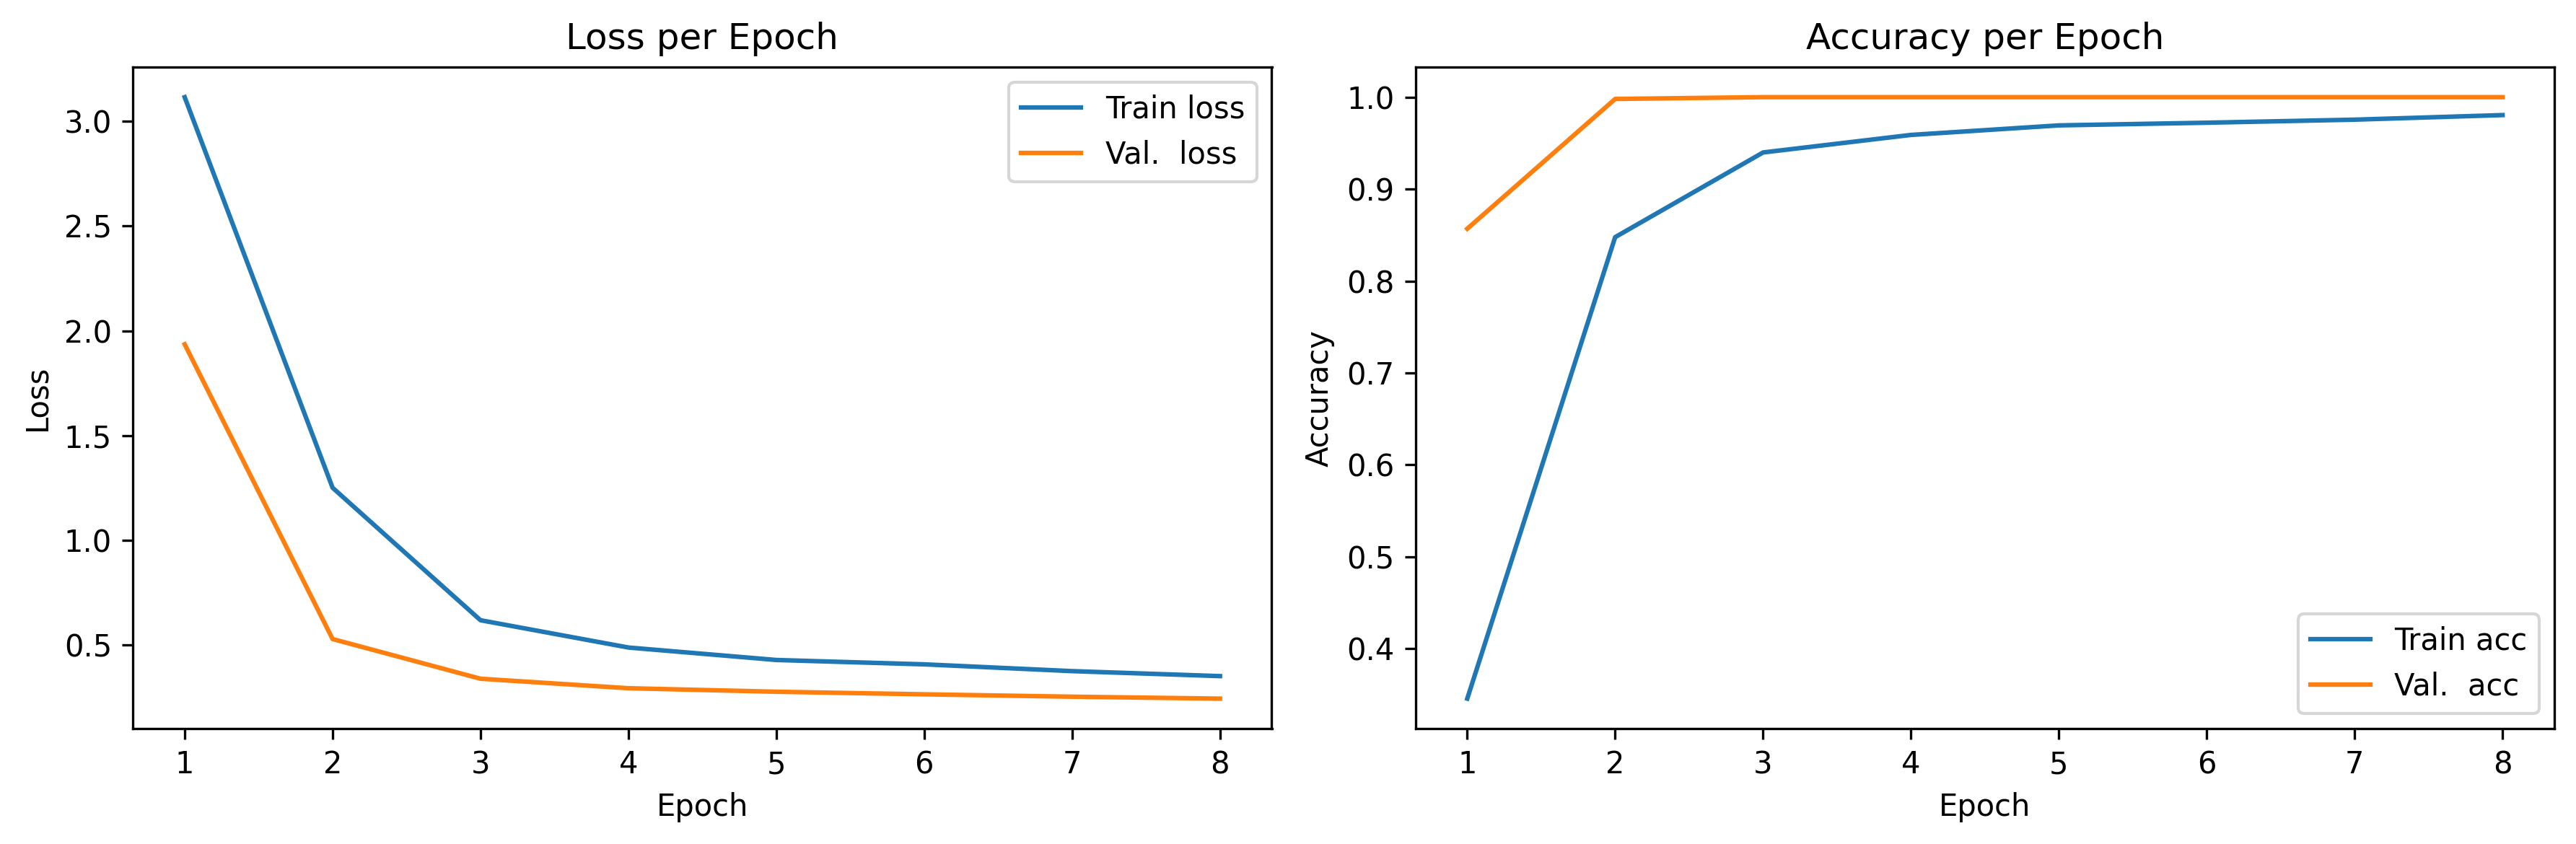

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 1.0000 - loss: 0.3467
L2 + EarlyStopping: Test loss: 0.3477,  Test accuracy: 1.0000


In [133]:
# 1) Clear state & rebuild model (with L2 λ=0.01)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

model_l2 = Sequential([
    Input(shape=(X_train_nn.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(y_train_nn.shape[1], activation='softmax')
])
model_l2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2) EarlyStopping callback (same patience)
early_l2 = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# 3) Train with L2 + EarlyStopping
history_l2 = model_l2.fit(
    X_train_nn, 
    y_train_nn,
    validation_split=0.30,
    epochs=50,
    batch_size=16,
    callbacks=[early_l2],
    verbose=1
)

# 4) Plot Loss & Accuracy
epochs_l2 = len(history_l2.history['loss'])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1, epochs_l2+1), history_l2.history['loss'],    label='Train loss')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_loss'],label='Val.  loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, epochs_l2+1), history_l2.history['accuracy'],    label='Train acc')
plt.plot(range(1, epochs_l2+1), history_l2.history['val_accuracy'],label='Val.  acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()

# 5) Evaluate on hold‐out
loss_l2, acc_l2 = model_l2.evaluate(X_test_nn, y_test_nn, verbose=1)
print(f"L2 + EarlyStopping: Test loss: {loss_l2:.4f},  Test accuracy: {acc_l2:.4f}")

### **Model Accuracy on Corrupted Data**

In [ ]:
# Get all scikit-learn models in the Models_Fulldata directory
import os

# Create a list to hold the models
models = []

for model_name in os.listdir('./Models_Fulldata'):
    # Check if the file is a .pkl file
    if model_name.endswith('.pkl'):
        # Load the model using joblib
        model = joblib.load('./Models_Fulldata/' + model_name)
        # Append the model to the list
        models.append(model)

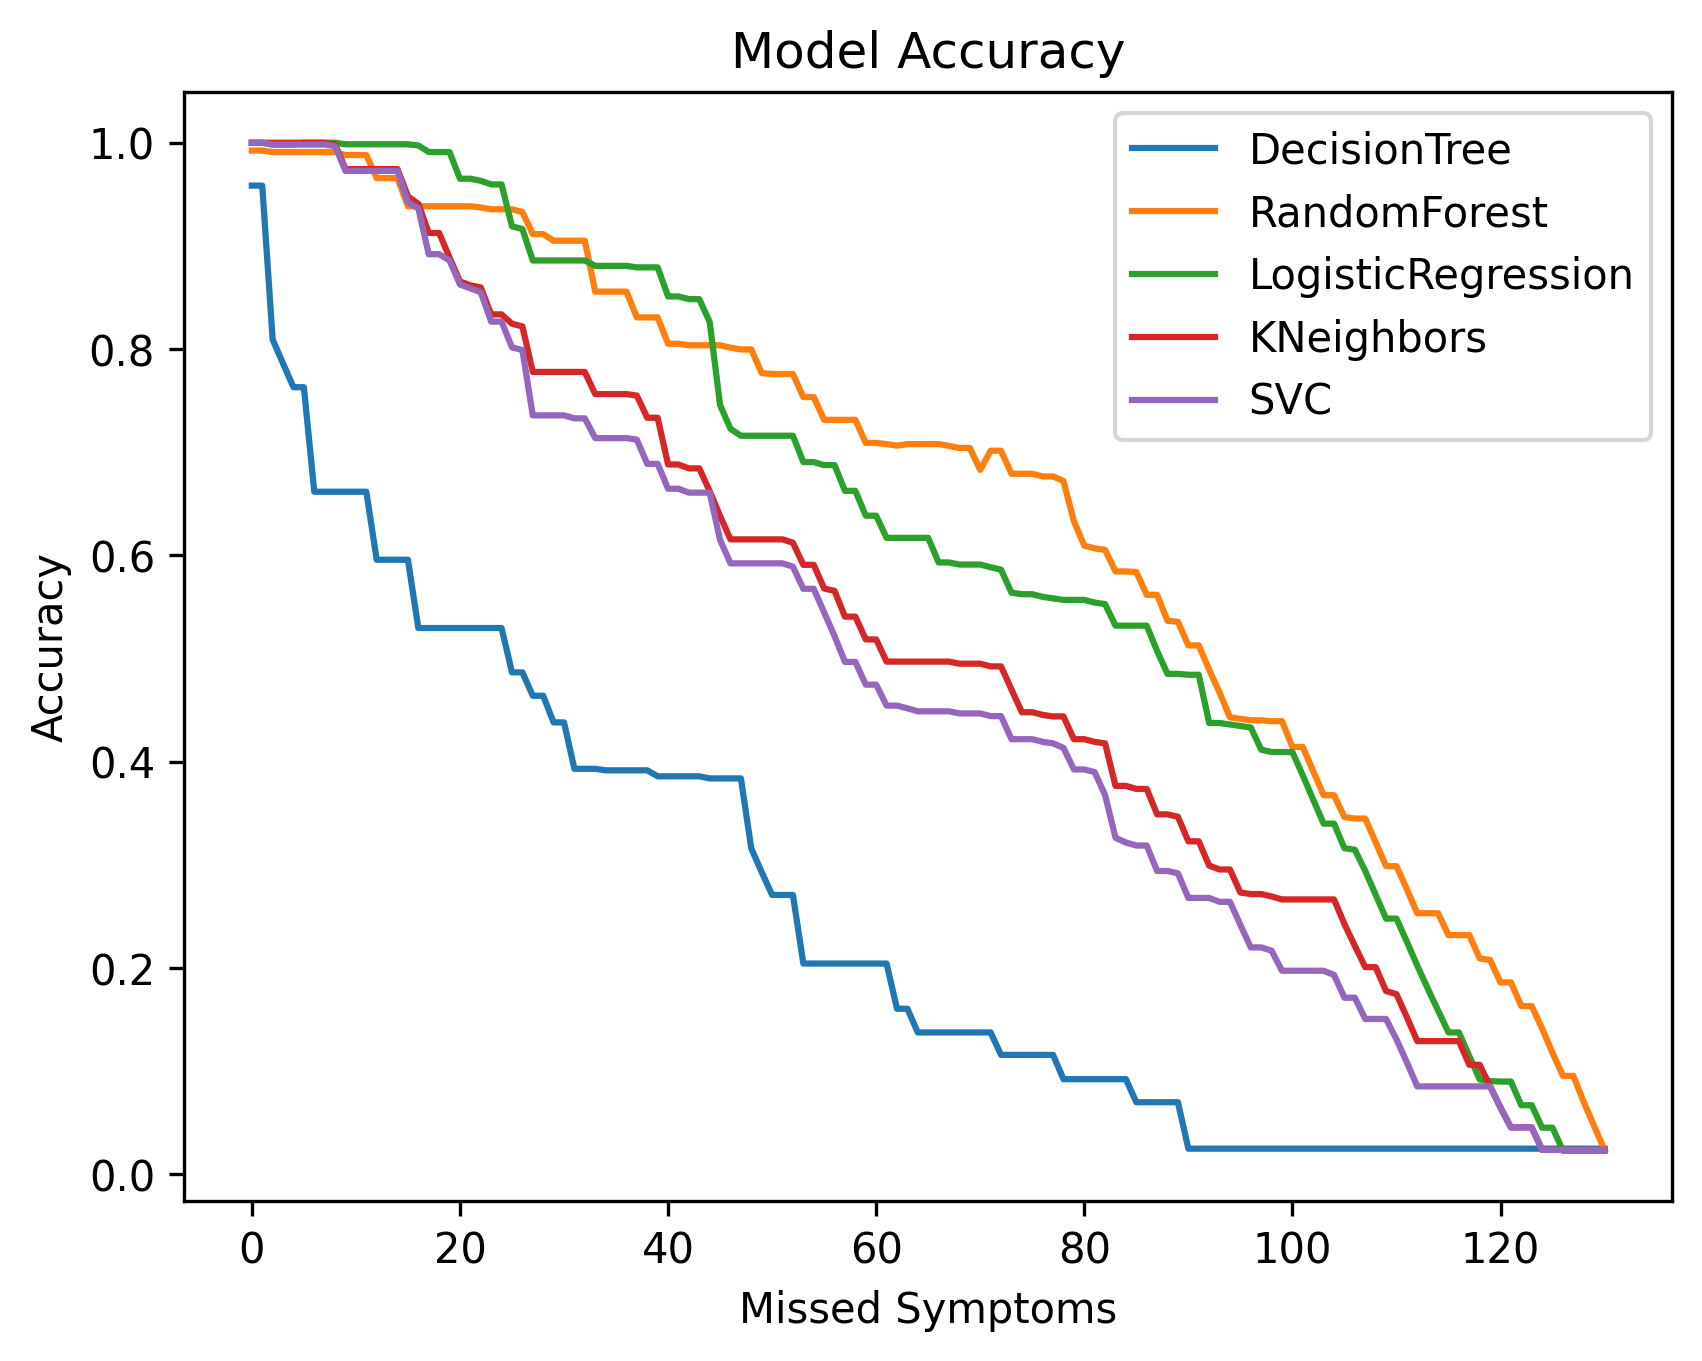

In [ ]:
#drop a random symptom from a patient
X_sub = binary.drop(columns=['Disease'])  # All columns except Disease
y_sub = binary['Disease']  # Target column

#Split the data
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.7, random_state=42)

dt_accs = []
rf_acces = []
log_acces = []
svm_acces = []
knn_acces = []

accs = [dt_accs, rf_acces, log_acces, svm_acces, knn_acces]

np.random.seed(42)  # Set the random seed for reproducibility

for i in range(len(unique_symptoms)):

    index, columns = np.where(X_test_sub == 1)

    random_symptom_index = np.random.choice(columns)

    #print(f"Random Patient Index: {random_patient_index}, Random Symptom Index: {random_symptom_index}")

    X_test_sub.iloc[:, random_symptom_index] = 0 # Set the symptom to 0 (not present)

    for j in range(len(models)):

        predictions = models[j].predict(X_test_sub)

        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)

        accs[j].append(accuracy)

# Plot the accuracies
for k, model in enumerate(models):
    # Plot the accuracies for each model
    plt.plot(accs[k], label=model.__class__.__name__.split('Classifier')[0])

plt.xlabel('Missed Symptoms')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
# Save figure
plt.savefig('./Plots/Classifier_Fulldata/model_accuracy_test1.pdf')
plt.show()

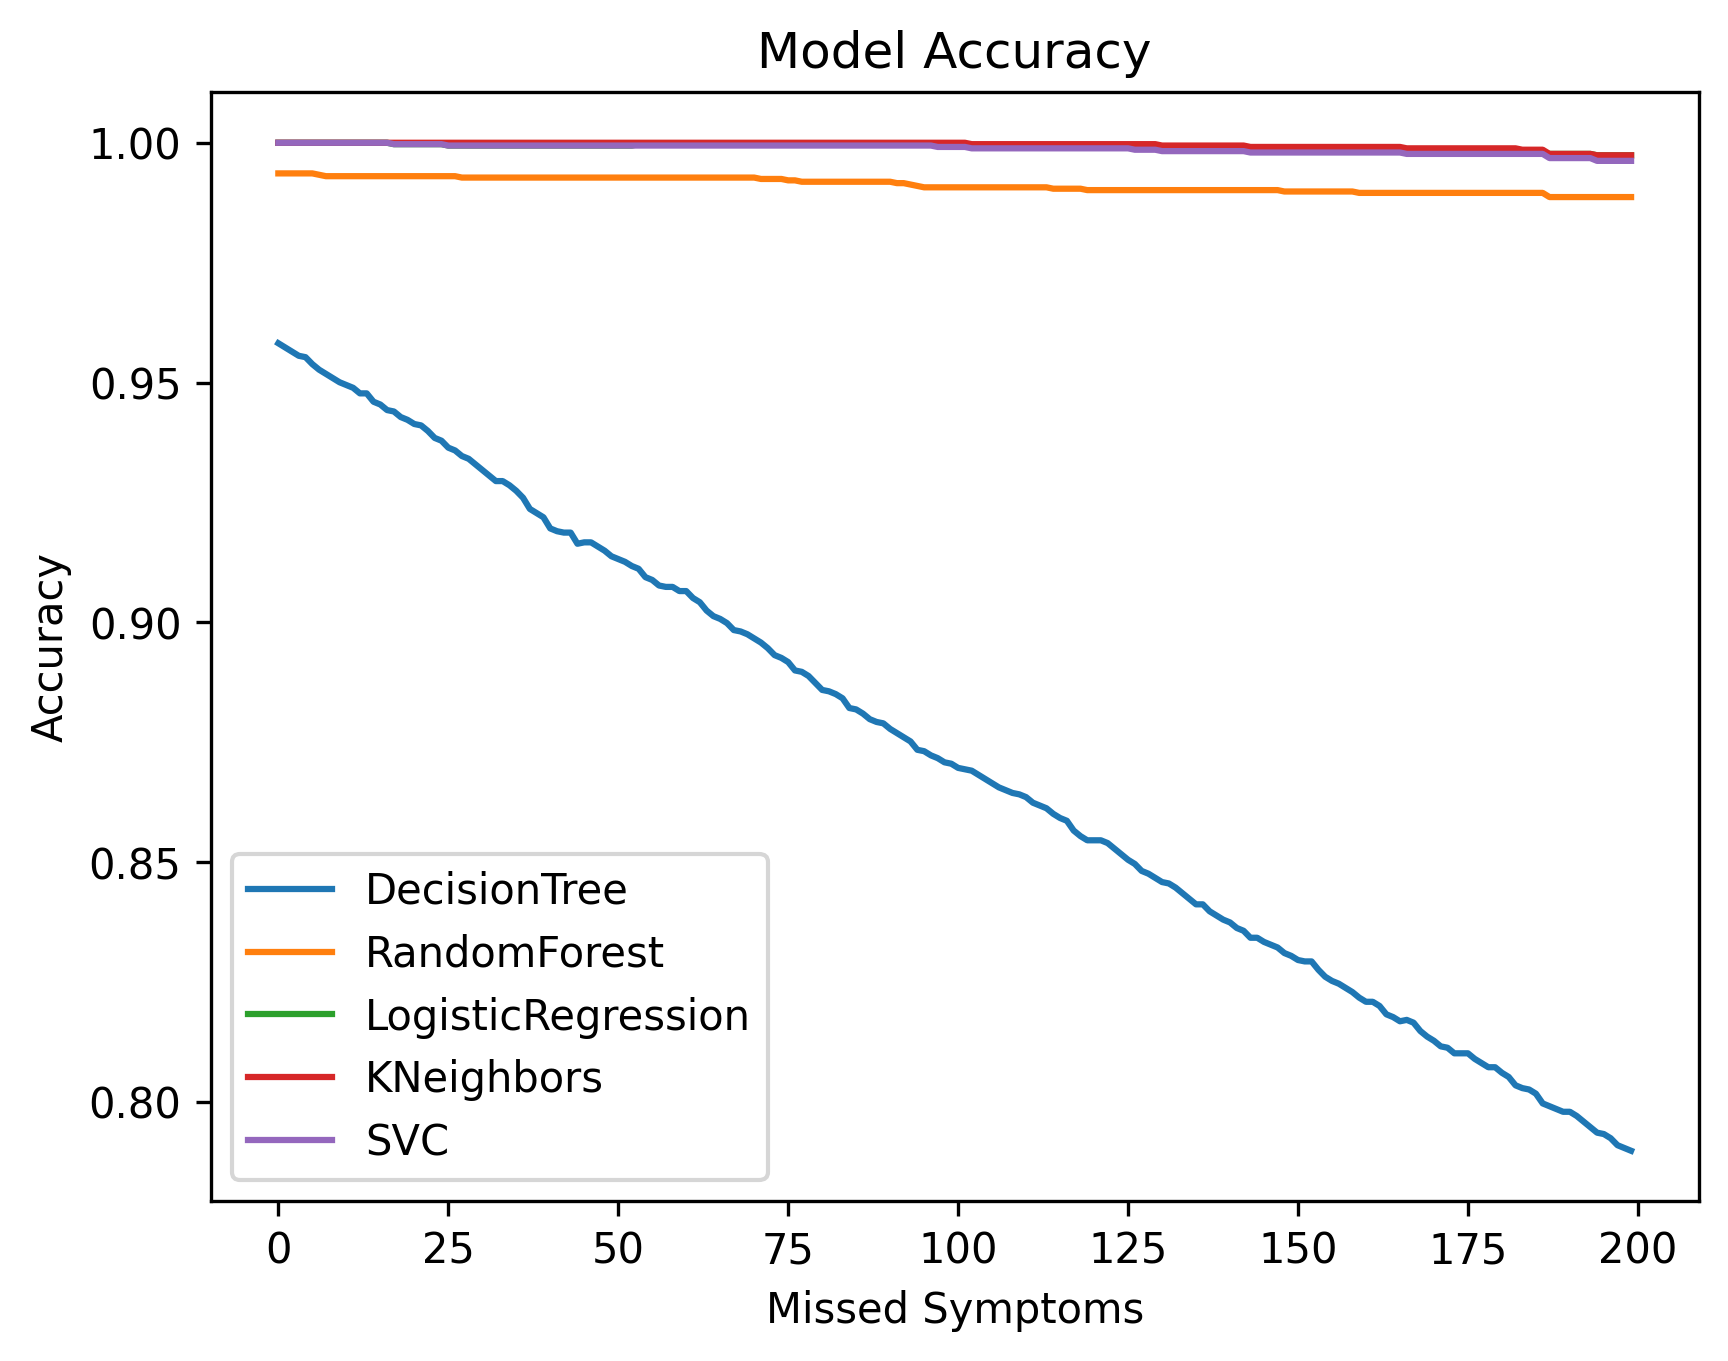

In [ ]:
X_sub = binary.drop(columns=['Disease'])  # All columns except Disease
y_sub = binary['Disease']  # Target column

#Split the data
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.7, random_state=42)

dt_accs = []
rf_acces = []
log_acces = []
svm_acces = []
knn_acces = []

accs = [dt_accs, rf_acces, log_acces, svm_acces, knn_acces]

np.random.seed(42)  # Set the random seed for reproducibility

for i in range(200):
    #Drop a random symptom from a random patient
    index, columns = np.where(X_test_sub == 1)

    for k in range(100):

        random_patient_index = np.random.choice(index)
        random_symptom_index = np.random.choice(columns)

        #print(f"Random Patient Index: {random_patient_index}, Random Symptom Index: {random_symptom_index}")

        X_test_sub.iloc[random_patient_index, random_symptom_index] = 0 # Set the symptom to 0 (not present)

    for j in range(len(models)):

        predictions = models[j].predict(X_test_sub)

        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)

        accs[j].append(accuracy)

# Plot the accuracies
for k, model in enumerate(models):
    # Plot the accuracies for each model
    plt.plot(accs[k], label=model.__class__.__name__.split('Classifier')[0])

plt.xlabel('Missed Symptoms')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
# Save plot
plt.savefig('./Plots/Classifier_Fulldata/model_accuracy_test2.pdf')
plt.show()
